In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
# Dominio de -1 a 1 en 64 datos debibo a los 6 genes
# 000 000, 000 001, ... , 111 111
x = np.linspace(-1, 1, 64)
y = x**2

print(x)
print(y)

[-1.         -0.96825397 -0.93650794 -0.9047619  -0.87301587 -0.84126984
 -0.80952381 -0.77777778 -0.74603175 -0.71428571 -0.68253968 -0.65079365
 -0.61904762 -0.58730159 -0.55555556 -0.52380952 -0.49206349 -0.46031746
 -0.42857143 -0.3968254  -0.36507937 -0.33333333 -0.3015873  -0.26984127
 -0.23809524 -0.20634921 -0.17460317 -0.14285714 -0.11111111 -0.07936508
 -0.04761905 -0.01587302  0.01587302  0.04761905  0.07936508  0.11111111
  0.14285714  0.17460317  0.20634921  0.23809524  0.26984127  0.3015873
  0.33333333  0.36507937  0.3968254   0.42857143  0.46031746  0.49206349
  0.52380952  0.55555556  0.58730159  0.61904762  0.65079365  0.68253968
  0.71428571  0.74603175  0.77777778  0.80952381  0.84126984  0.87301587
  0.9047619   0.93650794  0.96825397  1.        ]
[1.00000000e+00 9.37515747e-01 8.77047115e-01 8.18594104e-01
 7.62156715e-01 7.07734946e-01 6.55328798e-01 6.04938272e-01
 5.56563366e-01 5.10204082e-01 4.65860418e-01 4.23532376e-01
 3.83219955e-01 3.44923154e-01 3.08641

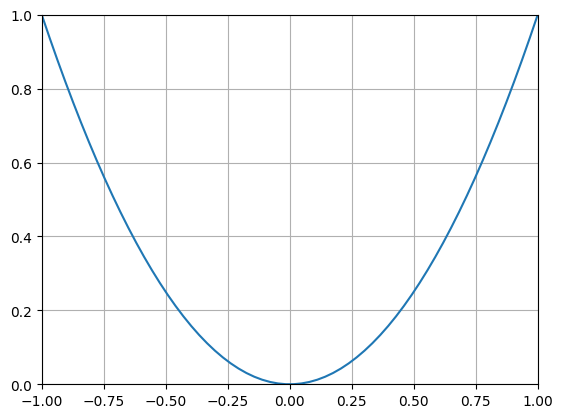

In [3]:
plt.plot(x, y)
plt.axis([-1, 1, 0, 1])
plt.grid(True)
plt.show()

No es necesario tener toda la poblacion generada, habra casos donde no se pueda generar todos y solo necesitamos 10 individuos para empezar la cruza, el objetivo es justamente con una poblacion pequeña alcanzar lo optimo.

# Generar Poblacion

In [41]:
step = 64
valores = np.linspace(-1, 1, step)  # 64 valores entre -1 y 1

def bin2val(binario, valores):
    idx = int(binario, 2)
    return valores[idx]

def generar_individuo():
    # Índice entre 0 y 63
    idx = random.randint(0, step-1)
    # Decimal a Binario
    binario = format(idx, '06b')
    valor = bin2val(binario, valores)
    return binario, valor

# Generar padres
padres = []
val = []
for _ in range(10):
    b, v = generar_individuo()
    padres.append(b)
    val.append(v)
    print(f"{b} -> {v}")


011100 -> -0.11111111111111116
100110 -> 0.20634920634920628
101100 -> 0.39682539682539675
111011 -> 0.873015873015873
001001 -> -0.7142857142857143
010001 -> -0.46031746031746035
101001 -> 0.3015873015873014
001110 -> -0.5555555555555556
011001 -> -0.2063492063492064
010001 -> -0.46031746031746035


Creamos nuestra poblacion inicial junto con su aptitud

In [42]:
df = pd.DataFrame({
    'Bin': padres,
    'Valor': val
})
df['fitness'] = df['Valor']**2

In [43]:
display(df)

,Bin,Valor,fitness
0,011100,-0.111111,0.012346
1,100110,0.206349,0.042580
2,101100,0.396825,0.157470
3,111011,0.873016,0.762157
4,001001,-0.714286,0.510204
5,010001,-0.460317,0.211892
6,101001,0.301587,0.090955
7,001110,-0.555556,0.308642
8,011001,-0.206349,0.042580
9,010001,-0.460317,0.211892


Ordenar segun su aptitud

In [44]:
df.sort_values(by='fitness', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
#df.to_csv('poblacion_inicial.csv', index=False) # Guardar para replicar despues
display(df)

,Bin,Valor,fitness
0,111011,0.873016,0.762157
1,001001,-0.714286,0.510204
2,001110,-0.555556,0.308642
3,010001,-0.460317,0.211892
4,010001,-0.460317,0.211892
5,101100,0.396825,0.157470
6,101001,0.301587,0.090955
7,011001,-0.206349,0.042580
8,100110,0.206349,0.042580
9,011100,-0.111111,0.012346


Llevaremos un registro de las generaciones para lo cual tomaremos dos valores representativos de cada generacion, siendo estos el mejor valor de aptitud asi como el promedio de la generacion.  
Partiendo de los padres inicales esta sera nuestra Generacion 0.

In [45]:
Top_Fitness = []
Avg_Fitness = []
Top_Fitness.append(df['fitness'].max())
Avg_Fitness.append(df['fitness'].mean())

In [46]:
print(Top_Fitness)
print(Avg_Fitness)

[np.float64(0.762156714537667)]
[np.float64(0.23507180650037793)]


# Seleccion

Con nuestros 10 padres creados procedemos a la cruza  
Para esto haremos 5 parejas y cada una tendra 2 hijos


## Metodos de selección

Separaremos los padres en dos grupos segun su aptitud y usaremos dos metodos de selección, Rank y Torneo

Como proponemos 5 parejas y debido a sus aptitudes haremos 2 parejas con rank (Las que tienen mejor aptitud) y 3 por torneo(Con peor aptitud esperando que mejoren)

In [47]:
# Rank
df1 = df.iloc[:4]

# torneo
df2 = df.iloc[4:10]

In [48]:
display(df1)
display(df2)

,Bin,Valor,fitness
0,111011,0.873016,0.762157
1,001001,-0.714286,0.510204
2,001110,-0.555556,0.308642
3,010001,-0.460317,0.211892


,Bin,Valor,fitness
4,010001,-0.460317,0.211892
5,101100,0.396825,0.157470
6,101001,0.301587,0.090955
7,011001,-0.206349,0.042580
8,100110,0.206349,0.042580
9,011100,-0.111111,0.012346


### Rank
Formaremos parejas segun su rango de aptitud tomando asi:  
(1 - 2), (3 - 4), (5 - 6)

In [49]:
df_rs = df1.reset_index(drop=True) # Reiniciar índice para hacer nuestra cruza
display(df_rs)

,Bin,Valor,fitness
0,111011,0.873016,0.762157
1,001001,-0.714286,0.510204
2,001110,-0.555556,0.308642
3,010001,-0.460317,0.211892


In [50]:
def parejas_rank(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    for i in range(0, len(df_rs)-1, 2):
        if i+1 < len(df_rs):
            pareja = (df_rs.iloc[i], df_rs.iloc[i+1])
            parejas.append(pareja)
    return parejas

def cruza_corte(parejas, corte_n):
    hijos = []
    for p1, p2 in parejas:
        bin1 = p1['Bin']
        bin2 = p2['Bin']
        hijo1_bin = bin1[:corte_n] + bin2[corte_n:]
        hijo2_bin = bin2[:corte_n] + bin1[corte_n:]
        hijos.append(hijo1_bin)
        hijos.append(hijo2_bin)
    return hijos


In [51]:
parejas = parejas_rank(df1)
hijos_binarios = cruza_corte(parejas, 3)

for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 111011
Padre 2 Bin: 001001
---
Pareja 2:
Padre 1 Bin: 001110
Padre 2 Bin: 010001
---
Hijo 1 Bin: 111001
Hijo 2 Bin: 001011
Hijo 3 Bin: 001001
Hijo 4 Bin: 010110


In [52]:
gen1 = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1['Valor'] = gen1['Bin'].apply(lambda b: bin2val(b, valores))
gen1['fitness'] = gen1['Valor']**2

gen1_r = pd.concat([df_rs, gen1], ignore_index=True)

In [53]:
gen1_r.sort_values(by='fitness', ascending=False, inplace=True)
display(gen1_r)

,Bin,Valor,fitness
0,111011,0.873016,0.762157
4,111001,0.809524,0.655329
6,001001,-0.714286,0.510204
1,001001,-0.714286,0.510204
5,001011,-0.650794,0.423532
2,001110,-0.555556,0.308642
3,010001,-0.460317,0.211892
7,010110,-0.301587,0.090955


### Torneo

En una lista de n elementos formaremos parejas la siguiente manera:  
(1 - n), (2 - n-1), (3 - n-2) y asi sucesivamente

In [54]:
df_ts = df2.reset_index(drop=True)
display(df_ts)

,Bin,Valor,fitness
0,010001,-0.460317,0.211892
1,101100,0.396825,0.157470
2,101001,0.301587,0.090955
3,011001,-0.206349,0.042580
4,100110,0.206349,0.042580
5,011100,-0.111111,0.012346


In [56]:
def parejas_tournament(df):
    df_rs = df.reset_index(drop=True)
    parejas = []
    n = len(df_rs)
    for i in range(n // 2):
        pareja = (df_rs.iloc[i], df_rs.iloc[n - 1 - i])
        parejas.append(pareja)
    return parejas

parejas = parejas_tournament(df2)
hijos_binarios = cruza_corte(parejas, 3)
for idx, (p1, p2) in enumerate(parejas):
    print(f"Pareja {idx+1}:")
    print("Padre 1 Bin:", p1['Bin'])
    print("Padre 2 Bin:", p2['Bin'])
    print("---")

for idx, hijo_bin in enumerate(hijos_binarios):
    print(f"Hijo {idx+1} Bin:", hijo_bin)

Pareja 1:
Padre 1 Bin: 010001
Padre 2 Bin: 011100
---
Pareja 2:
Padre 1 Bin: 101100
Padre 2 Bin: 100110
---
Pareja 3:
Padre 1 Bin: 101001
Padre 2 Bin: 011001
---
Hijo 1 Bin: 010100
Hijo 2 Bin: 011001
Hijo 3 Bin: 101110
Hijo 4 Bin: 100100
Hijo 5 Bin: 101001
Hijo 6 Bin: 011001


In [57]:
gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
gen1_t['fitness'] = gen1_t['Valor']**2

gen1_t = pd.concat([df_ts, gen1_t], ignore_index=True)
display(gen1_t)

,Bin,Valor,fitness
0,010001,-0.460317,0.211892
1,101100,0.396825,0.157470
2,101001,0.301587,0.090955
3,011001,-0.206349,0.042580
4,100110,0.206349,0.042580
5,011100,-0.111111,0.012346
6,010100,-0.365079,0.133283
7,011001,-0.206349,0.042580
8,101110,0.460317,0.211892
9,100100,0.142857,0.020408


Una vez que hemos hecho nuestras dos cruzas uniremos toda nuestra poblacion y obtenemos nuestros datos de control

In [58]:
gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
gen1.sort_values(by='fitness', ascending=False, inplace=True)
gen1.reset_index(drop=True, inplace=True)
display(gen1)

,Bin,Valor,fitness
0,111011,0.873016,0.762157
1,111001,0.809524,0.655329
2,001001,-0.714286,0.510204
3,001001,-0.714286,0.510204
4,001011,-0.650794,0.423532
5,001110,-0.555556,0.308642
6,010001,-0.460317,0.211892
7,010001,-0.460317,0.211892
8,101110,0.460317,0.211892
9,101100,0.396825,0.157470


De estos tomaremos solo los 10 más aptos que pasaran a la siguiente generacion.

In [59]:
gen1 = gen1.iloc[:10]
print(gen1)

      Bin     Valor   fitness
0  111011  0.873016  0.762157
1  111001  0.809524  0.655329
2  001001 -0.714286  0.510204
3  001001 -0.714286  0.510204
4  001011 -0.650794  0.423532
5  001110 -0.555556  0.308642
6  010001 -0.460317  0.211892
7  010001 -0.460317  0.211892
8  101110  0.460317  0.211892
9  101100  0.396825  0.157470


In [60]:
Top_Fitness.append(gen1['fitness'].max())
Avg_Fitness.append(gen1['fitness'].mean())

In [62]:
print(f'Top Fitness: {Top_Fitness}')
print(f'Avg Fitness: {Avg_Fitness}')

Top Fitness: [np.float64(0.762156714537667), np.float64(0.762156714537667)]
Avg Fitness: [np.float64(0.23507180650037793), np.float64(0.39632149155958674)]


Esto marca el final de nuestra primera generacion ya que se hizo la cruza y nos quedamos con los 10 mayormente aptos, con lo hecho anteriormente ahora solo queda repetir el proceso hasta completar el criterio de paro.

In [63]:
for i in range(5): # Repetir el proceso de selección, cruza y reemplazo
    # Rank
    df1 = gen1.iloc[:4]
    # torneo
    df2 = gen1.iloc[4:10]


    # Cruza por rank
    parejas = parejas_rank(df1)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_r = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_r['Valor'] = gen1_r['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_r['fitness'] = gen1_r['Valor']**2
    gen1_r = pd.concat([df1.reset_index(drop=True), gen1_r], ignore_index=True)

    # Cruza por torneo
    parejas = parejas_tournament(df2)
    hijos_binarios = cruza_corte(parejas, 3)
    gen1_t = pd.DataFrame(hijos_binarios, columns=['Bin'])
    gen1_t['Valor'] = gen1_t['Bin'].apply(lambda b: bin2val(b, valores))
    gen1_t['fitness'] = gen1_t['Valor']**2
    gen1_t = pd.concat([df2.reset_index(drop=True), gen1_t], ignore_index=True)


    # Unir y seleccionar los mejores 10
    gen1 = pd.concat([gen1_r, gen1_t], ignore_index=True)
    gen1.sort_values(by='fitness', ascending=False, inplace=True)
    gen1.reset_index(drop=True, inplace=True)
    gen1 = gen1.iloc[:10]
    # Registrar estadísticas
    Top_Fitness.append(gen1['fitness'].max())
    Avg_Fitness.append(gen1['fitness'].mean())

In [65]:
print(gen1)

      Bin     Valor   fitness
0  111011  0.873016  0.762157
1  111011  0.873016  0.762157
2  111011  0.873016  0.762157
3  111011  0.873016  0.762157
4  111011  0.873016  0.762157
5  111011  0.873016  0.762157
6  111011  0.873016  0.762157
7  111011  0.873016  0.762157
8  111011  0.873016  0.762157
9  111011  0.873016  0.762157


In [64]:
print(f'Top Fitness: {Top_Fitness}')
print(f'Avg Fitness: {Avg_Fitness}')

Top Fitness: [np.float64(0.762156714537667), np.float64(0.762156714537667), np.float64(0.762156714537667), np.float64(0.762156714537667), np.float64(0.762156714537667), np.float64(0.762156714537667), np.float64(0.762156714537667)]
Avg Fitness: [np.float64(0.23507180650037793), np.float64(0.39632149155958674), np.float64(0.5682539682539682), np.float64(0.6690350214159737), np.float64(0.7407911312673217), np.float64(0.7621567145376671), np.float64(0.7621567145376671)]


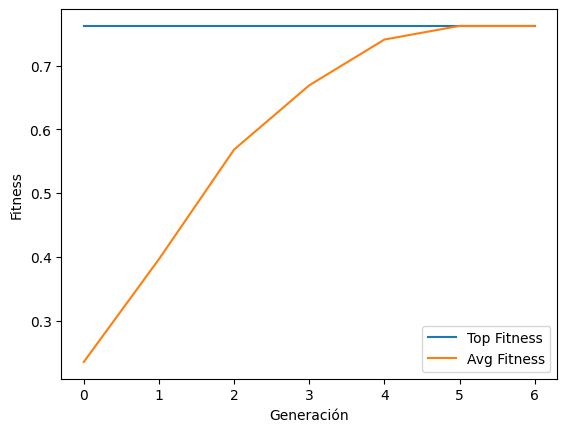

In [ ]:
plt.plot(Top_Fitness, label='Top Fitness')
plt.plot(Avg_Fitness, label='Avg Fitness')
plt.xlabel('Generación')
plt.ylabel('Fitness')
plt.legend()
plt.show()

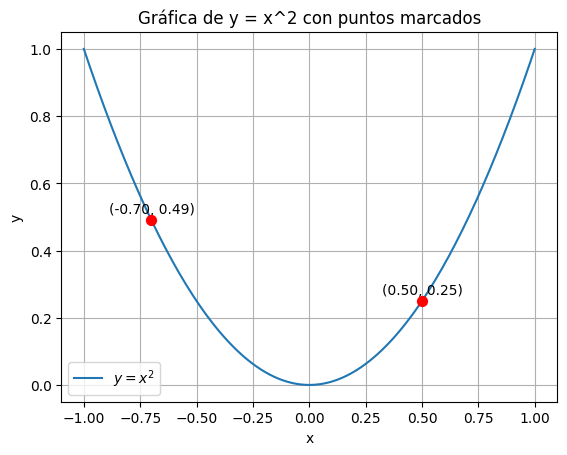

In [68]:
# Rango de x
x = np.linspace(-1, 1, 200)
y = x**2

# Lista de puntos (ejemplo: dos puntos en (0.5, 0.25) y (-0.7, 0.49))
puntos = [(0.5, 0.5**2), (-0.7, (-0.7)**2)]

# Graficar la función
plt.plot(x, y, label='$y = x^2$')

# Marcar los puntos
for px, py in puntos:
    plt.scatter(px, py, color='red', s=50, zorder=5)  # punto
    plt.text(px, py + 0.02, f"({px:.2f}, {py:.2f})", ha='center')  # etiqueta

plt.xlabel("x")
plt.ylabel("y")
plt.title("Gráfica de y = x^2 con puntos marcados")
plt.legend()
plt.grid(True)
plt.show()